In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [3]:
args = type('', (), {})() # Google "creating an empty object in Python"
args.cuda = torch.cuda.is_available()
args.batch_size = 128
args.epochs = 5
args.seed = 1
args.log_interval = 50 # how many batches to wait before logging training status

In [4]:
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [5]:
kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=False, **kwargs)

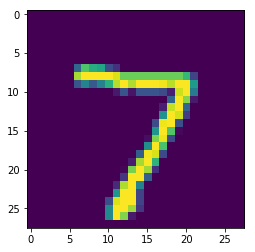

In [6]:
def get_test_img(ind=0):
    batch_idx, (data, ys) = next(enumerate(test_loader))
    test_img = Variable(data[ind:ind+1])
    return test_img

def show_test_img(ind=0):
    plt.imshow(get_test_img(ind).view(28,28).data)
    
def show_img(img):
    plt.imshow(img.view(28,28).data)
    
show_test_img()

In [7]:
img = get_test_img()
H = img.shape[-2]
W = img.shape[-1]

In [170]:
##### Loop version
# from itertools import product
    
# class Tree(nn.Module):
#     def __init__(self):
#         super(Tree, self).__init__()
#         self.HEIGHT = 3 # IN-BETWEEN height
#         layer_sizes = [32, 64, 128, 784] # Last element is always H*W
#         _ts = [None] # Putting it here to make indexing easier
#         for layer in range(self.HEIGHT):
#             layer_size = layer_sizes[layer]
#             layer_size_next = layer_sizes[layer+1]
#             for _ in range(2**(layer+1)):
#                 _ts.append(nn.Linear(layer_size, layer_size_next))
#         self.transforms = nn.ModuleList(_ts)
        
#         #self.relu = nn.ReLU() # TODO use ReLU
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, noise):
#         acc = []
#         for path in product([0,1], repeat=self.HEIGHT):
#             node = 0 # root
#             sofar = noise #self.sigmoid(self.transforms[node](noise))
#             for p in path:
#                 node = node*2 + 1 + p
#                 sofar = self.sigmoid(self.transforms[node](sofar))
#             acc.append(sofar)
#         return acc
    
# model = Tree()

In [186]:
#### List version (probably better on GPU)
from itertools import product
    
class Tree(nn.Module):
    def __init__(self):
        super(Tree, self).__init__()
        
        self.HEIGHT = 3 # IN-BETWEEN height
        
        # Transforms
        layer_sizes = [32, 64, 128, 784] # Last element is always H*W
        _ts = [None] # Putting it here to make indexing easier
        for layer in range(self.HEIGHT):
            layer_size = layer_sizes[layer]
            layer_size_next = layer_sizes[layer+1]
            for _ in range(2**(layer+1)):
                _ts.append(nn.Linear(layer_size, layer_size_next))
        #self.transforms = nn.ModuleList(_ts)
        
        #relu = nn.ReLU() # TODO try use ReLU
        sigmoid = nn.Sigmoid()
        
        _path_networks = []
        for path in product([0,1], repeat=self.HEIGHT):
            _seq = []
            node = 0 # root
            for p in path:
                node = node*2 + 1 + p
                _seq.append(_ts[node])
                _seq.append(sigmoid)
            _path_networks.append(nn.Sequential(*_seq))
        self.path_networks = nn.ModuleList(_path_networks)

    def forward(self, noise):
        return [net(noise) for net in self.path_networks]
    
model = Tree()

debug:

In [187]:
target = img.view(img.shape[0], img.shape[1], 28*28)
noise = torch.zeros(target.shape[0], target.shape[1], 32)
noise = Variable(noise)
noise.shape

torch.Size([1, 1, 32])

In [188]:
output = model(noise)

In [189]:
output[0].shape

torch.Size([1, 1, 784])

In [190]:
losses = [F.binary_cross_entropy(out, target, size_average=True) for out in output]
loss = torch.stack(losses).sum()
loss

Variable containing:
 5.6343
[torch.FloatTensor of size 1]

---

In [195]:
model = Tree()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [196]:
%%time

def train(epoch):
    model.train()
    for batch_idx, (data, ys) in enumerate(train_loader):
        target = data.view(data.shape[0], data.shape[1], 28*28)
        #noise = torch.zeros(target.shape[0], target.shape[1], 32)
        noise = torch.randn(target.shape[0], target.shape[1], 32)

        noise = Variable(noise)
        target = Variable(target)
        if args.cuda:
            noise = noise.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        
        output = model(noise)
        losses = [F.binary_cross_entropy(out, target, size_average=True) for out in output]
        loss = torch.stack(losses).sum()
        
        loss.backward()
        optimizer.step()
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
            
for epoch in range(1):
    train(epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 5.613353
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.236676
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.164144
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.088080
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.132589
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.145200
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.084360
Train Epoch: 0 [44800/60000 (75%)]	Loss: 2.090288
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.072750
Train Epoch: 0 [57600/60000 (96%)]	Loss: 2.143508
CPU times: user 42 s, sys: 1.43 s, total: 43.4 s
Wall time: 36.3 s


---

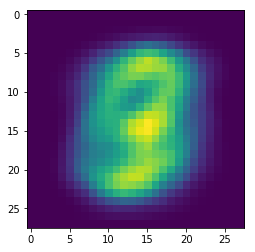

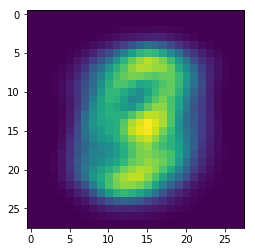

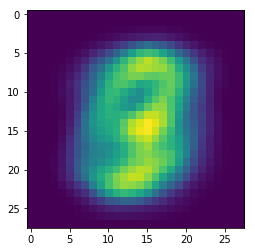

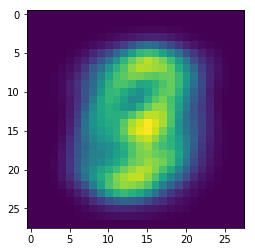

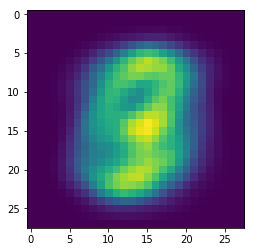

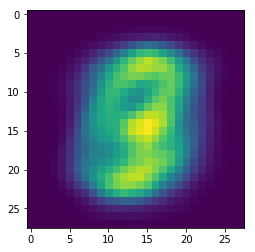

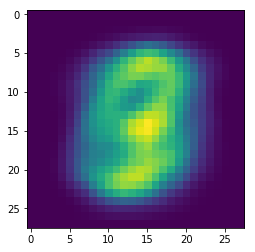

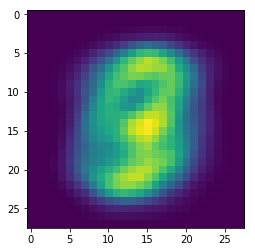

In [199]:
target = img.view(img.shape[0], img.shape[1], 28*28)
#noise = torch.zeros(target.shape[0], target.shape[1], 32)
noise = torch.randn(target.shape[0], target.shape[1], 32)
noise = Variable(noise)
output = model(noise)
for out in output:
    out = out.cpu().data.view(28, 28)
    plt.imshow(out)
    plt.show()